In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Loading data

Data is provided by a link in the folder data. Enjoy yourself!!!

In [2]:
training_data = np.loadtxt('facial_recog/fer2013_training_onehot.csv', delimiter=',')

In [3]:
testing_data = np.loadtxt('facial_recog/fer2013_publictest_onehot.csv', delimiter=',')

In [4]:
training_data

array([[  70.,   80.,   82., ...,    0.,    0.,    0.],
       [ 151.,  150.,  147., ...,    0.,    0.,    0.],
       [ 231.,  212.,  156., ...,    0.,    0.,    0.],
       ..., 
       [  74.,   81.,   87., ...,    1.,    0.,    0.],
       [ 222.,  227.,  203., ...,    0.,    0.,    0.],
       [ 195.,  199.,  205., ...,    1.,    0.,    0.]])

In [5]:
def print_samples(data, n, label, emo_dict):
    seed = len(data)
    for i in range(n):
        j = random.randint(1, seed)
        sample_img = data[j, :]
        sample_img = np.reshape(sample_img, (48, 48))
        
        sample_label = label[j, : ]
        n_dict = np.argmax(sample_label)
        print('Emoion :', emo_dict[n_dict])
        plt.imshow(sample_img, cmap='gray')
        plt.show()
    

In [6]:
def load_data(train, test, n_inputs, n_classes):
    
    dim = len(train)
    x_tr = train[:, 0:n_inputs]
    y_tr = train[:, n_inputs:n_inputs + n_classes]
    
    x_te = test[:, 0:n_inputs]
    y_te = test[:, n_inputs:n_inputs + n_classes]
    
    x_tr = np.reshape(x_tr, (-1, 48, 48, 1))
    #x_tr = np.expand_dims(x_tr, axis=4)
    
    x_te = np.reshape(x_te, (-1, 48, 48, 1))
    #x_te = np.expand_dims(x_te, axis=4)
    
    return x_tr, y_tr, x_te, y_te

In [7]:
data_lenght = len(training_data)
n_inputs = 2304
n_classes = 7
X_tr, Y_tr, X_te, Y_te = load_data(training_data, testing_data, n_inputs, n_classes)

print('Training input data shape:', X_tr.shape)
print('Training labels data shape:', Y_tr.shape)
print('Testing input data shape:', X_te.shape)
print('Testing labels data shape:', Y_te.shape)


Training input data shape: (28709, 48, 48, 1)
Training labels data shape: (28709, 7)
Testing input data shape: (3589, 48, 48, 1)
Testing labels data shape: (3589, 7)


Emoion : fear


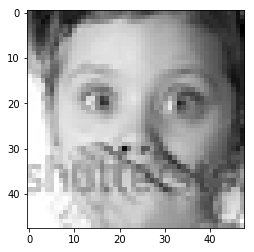

Emoion : neutral


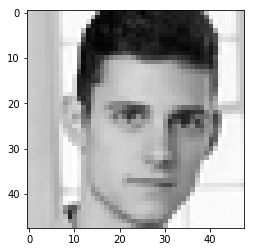

Emoion : happy


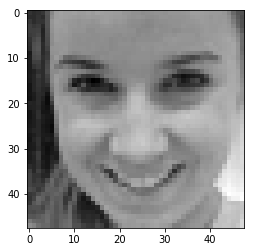

In [8]:
import random
emo_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
samples = 3
print_samples(X_tr, samples, Y_tr, emo_dict)

In [61]:
tf.reset_default_graph()
sess = tf.Session()

In [62]:
def weight_var(shape):
    w = tf.truncated_normal(shape=shape, mean=0, stddev=0.1)
    return tf.Variable(w)

def bias_var(shape):
    return tf.Variable(tf.zeros(shape))


def CNN(x_):
    filter_ = 5
    strides1 = [1, 1, 1, 1]
    strides2 = [1, 2, 2, 1]
    ksize = strides2
    
    w1 = weight_var(shape=[3, 3, 1, 6])   
    b1 = bias_var(6)
    layer1 = tf.nn.conv2d(x_, w1, strides=strides1, padding='VALID')  #(, 44, 44, 64)
    layer1 = tf.nn.bias_add(layer1, b1)
    layer1 = tf.nn.relu(layer1)
    print(layer1.get_shape)
    layer1 = tf.nn.max_pool(layer1, ksize=ksize, strides=strides2, padding='VALID') #(, 22, 22, 64)
    
    
    w2 = weight_var(shape=[3, 3, 6, 9])
    b2 = bias_var(9)
    layer2 = tf.nn.conv2d(layer1, w2, strides=strides1, padding='VALID') #(, 18, 18, 64)
    layer2 = tf.nn.bias_add(layer2, b2)
    print(layer2.get_shape)
    
    
    layer2 = tf.nn.relu(layer2)
    
    layer2 = tf.nn.max_pool(layer2, ksize=ksize, strides=strides2, padding='VALID') #(, 9, 9, 64)
    
    w3 = weight_var(shape=[3, 3, 9, 16])
    b3 = bias_var(16)
    layer3 = tf.nn.conv2d(layer2, w3, strides=strides1, padding='VALID')
    layer3 = tf.nn.bias_add(layer3, b3)
    layer3 = tf.nn.relu(layer3)
    print(layer3.get_shape)
    layer3= tf.nn.max_pool(layer3, ksize=ksize, strides=strides2, padding='VALID')
    h = layer3.get_shape
    print(h)
    
    flatten = tf.contrib.layers.flatten(layer3)
    dim = flatten.get_shape().as_list()
    print(dim[1])
    wc1 = weight_var(shape=[(dim[1]), 256])
    b_c1 = bias_var(256)
    fc1 = tf.matmul(flatten, wc1) + b_c1
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)
    
    wc2 = weight_var(shape=[256, 64])
    b_c2 = bias_var(64)
    fc2 = tf.matmul(fc1, wc2) + b_c2
    fc2 = tf.nn.relu(fc2)
    
    wc3 = weight_var(shape=[64, n_classes])
    b_c3 = bias_var(n_classes)
    logits = tf.matmul(fc2, wc3) + b_c3
    
    return logits
    
    
    
    

In [63]:


x = tf.placeholder(dtype=tf.float32, shape=(None, 48, 48, 1))
y = tf.placeholder(dtype=tf.float32, shape=(None, n_classes))



logits = CNN(x)

<bound method Tensor.get_shape of <tf.Tensor 'Relu:0' shape=(?, 46, 46, 6) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'BiasAdd_1:0' shape=(?, 21, 21, 9) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'Relu_2:0' shape=(?, 8, 8, 16) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'MaxPool_2:0' shape=(?, 4, 4, 16) dtype=float32>>
256


In [64]:
softmax = tf.nn.softmax(logits)
learning_rate = 1e-3
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99).minimize(loss)

prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, dtype=tf.float32))



In [65]:
init = tf.global_variables_initializer()
sess.run(init)

In [68]:
train_loss_hist = []
train_acc = []
test_loss_hist = []
test_acc = []
epochs= 35


batch_size = 512
total_batches = X_tr.shape[0]//batch_size

import time as t
start = t.time()

length = len(X_tr)
m = 0

print('Initializing Training')
try:
    for i in range(epochs):        
        for j in range(total_batches):           
            index = (j * batch_size) % (length - batch_size)    
            batch_xs = X_tr[index: index + batch_size]
            batch_ys = Y_tr[index: index + batch_size]
            
            _, loss_, _, acc,  = sess.run([optimizer, loss, softmax, accuracy], feed_dict={x: batch_xs,
                                                                                           y: batch_ys
                                                                  })

            if i % 5 == 0:
                #_loss, _acc,  = sess.run([ loss, accuracy], feed_dict={x: X_te,
                                                                   #y: Y_te
                                                                  #})
                print('Epoch {} batch {} Train-loss: {} and Accuracy {}%'.format(i, j, loss_, 100 * acc))
                #print('Test-loss: {} and test Accuracy {}%'.format( _loss, 100 * _acc))
                #test_acc.append(_acc)
                train_acc.append(acc)
                #test_loss_hist.append(_loss)
                train_loss_hist.append(loss_)
        if i % 50 == 0:
            print(" ")
            #print(prediction)
except KeyboardInterrupt:
    print('Training Interrupted')
end = t.time()
print((end-start)/60, 'mins')

Initializing Training
Epoch 0 batch 0 Train-loss: 1.2558096647262573 and Accuracy 48.828125%
Epoch 0 batch 1 Train-loss: 1.2761321067810059 and Accuracy 51.171875%
Epoch 0 batch 2 Train-loss: 1.2539476156234741 and Accuracy 52.9296875%
Epoch 0 batch 3 Train-loss: 1.2570735216140747 and Accuracy 49.8046875%
Epoch 0 batch 4 Train-loss: 1.2513539791107178 and Accuracy 53.125%
Epoch 0 batch 5 Train-loss: 1.2888665199279785 and Accuracy 50.5859375%
Epoch 0 batch 6 Train-loss: 1.261162281036377 and Accuracy 52.734375%
Epoch 0 batch 7 Train-loss: 1.2752410173416138 and Accuracy 49.609375%
Epoch 0 batch 8 Train-loss: 1.2687604427337646 and Accuracy 51.5625%
Epoch 0 batch 9 Train-loss: 1.255570888519287 and Accuracy 53.515625%
Epoch 0 batch 10 Train-loss: 1.2178764343261719 and Accuracy 55.859375%
Epoch 0 batch 11 Train-loss: 1.2686361074447632 and Accuracy 49.8046875%
Epoch 0 batch 12 Train-loss: 1.2521222829818726 and Accuracy 53.3203125%
Epoch 0 batch 13 Train-loss: 1.323889136314392 and Acc

Epoch 10 batch 3 Train-loss: 1.1590819358825684 and Accuracy 54.4921875%
Epoch 10 batch 4 Train-loss: 1.1916967630386353 and Accuracy 56.8359375%
Epoch 10 batch 5 Train-loss: 1.1799033880233765 and Accuracy 54.296875%
Epoch 10 batch 6 Train-loss: 1.1526812314987183 and Accuracy 54.296875%
Epoch 10 batch 7 Train-loss: 1.1910336017608643 and Accuracy 56.8359375%
Epoch 10 batch 8 Train-loss: 1.1365044116973877 and Accuracy 58.7890625%
Epoch 10 batch 9 Train-loss: 1.1577874422073364 and Accuracy 55.46875%
Epoch 10 batch 10 Train-loss: 1.144958257675171 and Accuracy 56.4453125%
Epoch 10 batch 11 Train-loss: 1.1166880130767822 and Accuracy 57.421875%
Epoch 10 batch 12 Train-loss: 1.0894997119903564 and Accuracy 60.9375%
Epoch 10 batch 13 Train-loss: 1.1854146718978882 and Accuracy 54.296875%
Epoch 10 batch 14 Train-loss: 1.1812797784805298 and Accuracy 55.859375%
Epoch 10 batch 15 Train-loss: 1.1216113567352295 and Accuracy 60.7421875%
Epoch 10 batch 16 Train-loss: 1.153818964958191 and Accu

Epoch 20 batch 4 Train-loss: 1.1067917346954346 and Accuracy 57.8125%
Epoch 20 batch 5 Train-loss: 1.0991020202636719 and Accuracy 57.6171875%
Epoch 20 batch 6 Train-loss: 1.072350263595581 and Accuracy 57.421875%
Epoch 20 batch 7 Train-loss: 1.1433327198028564 and Accuracy 58.3984375%
Epoch 20 batch 8 Train-loss: 1.0767135620117188 and Accuracy 58.7890625%
Epoch 20 batch 9 Train-loss: 1.1192898750305176 and Accuracy 58.0078125%
Epoch 20 batch 10 Train-loss: 1.0296907424926758 and Accuracy 60.7421875%
Epoch 20 batch 11 Train-loss: 1.0915266275405884 and Accuracy 58.984375%
Epoch 20 batch 12 Train-loss: 1.074697494506836 and Accuracy 60.9375%
Epoch 20 batch 13 Train-loss: 1.0768595933914185 and Accuracy 54.6875%
Epoch 20 batch 14 Train-loss: 1.1089510917663574 and Accuracy 56.4453125%
Epoch 20 batch 15 Train-loss: 1.0280637741088867 and Accuracy 61.328125%
Epoch 20 batch 16 Train-loss: 1.091599941253662 and Accuracy 60.3515625%
Epoch 20 batch 17 Train-loss: 1.0803024768829346 and Accura

Epoch 30 batch 5 Train-loss: 1.0527199506759644 and Accuracy 58.3984375%
Epoch 30 batch 6 Train-loss: 1.0377309322357178 and Accuracy 61.5234375%
Epoch 30 batch 7 Train-loss: 1.0418245792388916 and Accuracy 60.546875%
Epoch 30 batch 8 Train-loss: 1.0185750722885132 and Accuracy 62.3046875%
Epoch 30 batch 9 Train-loss: 0.9950079321861267 and Accuracy 61.71875%
Epoch 30 batch 10 Train-loss: 0.9889302253723145 and Accuracy 63.0859375%
Epoch 30 batch 11 Train-loss: 1.024742603302002 and Accuracy 58.3984375%
Epoch 30 batch 12 Train-loss: 0.9781702160835266 and Accuracy 63.8671875%
Epoch 30 batch 13 Train-loss: 1.0076494216918945 and Accuracy 60.15625%
Epoch 30 batch 14 Train-loss: 1.0308315753936768 and Accuracy 60.7421875%
Epoch 30 batch 15 Train-loss: 0.983773946762085 and Accuracy 62.890625%
Epoch 30 batch 16 Train-loss: 0.983538031578064 and Accuracy 64.453125%
Epoch 30 batch 17 Train-loss: 1.0521280765533447 and Accuracy 57.2265625%
Epoch 30 batch 18 Train-loss: 1.0168306827545166 and 

In [ ]:
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
plt.rc('font', **font)

In [ ]:
width = 10
height = 10
plt.figure(figsize=(width, height))

plt.title("Training session's progress over iterations")
plt.plot(train_loss_hist, 'b-', label='Train Loss')
plt.plot(test_loss_hist, 'g--', label='Test Loss')
plt.xlabel('Training iteration')
plt.ylabel('Training Progress Loss')
plt.show()


In [ ]:
plt.figure(figsize=(width, height))
plt.plot(train_acc, 'g-', label='Train acc')
plt.plot(test_acc, 'g--', label='Test acc')
plt.title('Training session progress')
plt.xlabel('Training iteration')
plt.ylabel('Training Progress Accuracy')
plt.show()

In [ ]:
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
plt.rc('font', **font)

plt.figure(figsize=(width, height))

plt.title("Training session's progress over iterations")
plt.plot(train_loss_hist, 'g', label='Train Loss')
#plt.plot(test_loss_hist, '--', label='Test Loss')
plt.plot(train_acc, 'b', label='Train acc')
#plt.plot(test_acc, 'g-', label='Test acc')
plt.xlabel('Training iteration')
plt.ylabel('Training Progress Loss')
plt.show()